# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [25]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


## Env setup

In [26]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [27]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [28]:
# What model to download.
MODEL_NAME = 'outmymodel_resnet'
#MODEL_FILE = MODEL_NAME + '.tar.gz'
#DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training/data', 'object_detection.pbtxt')

NUM_CLASSES = 5

## Download Model

## Load a (frozen) Tensorflow model into memory.

In [29]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [30]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [31]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [32]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 105) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (8, 8)

In [33]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [34]:

data=pd.read_csv("solar_master_reasoning.csv")
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
def inspect_defect(image_path,options=True):
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  fig=plt.figure(figsize=(14,12))
  a=fig.add_subplot(1,2,1)
  plt.imshow(image_np)
  a.set_title("Input Image")
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)  
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  _,class_list = vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      min_score_thresh=0.5,
      line_thickness=8)
  a=fig.add_subplot(1,2,2)
  plt.imshow(image_np)
  a.set_title("After Defect Inspection")
  plt.show()
  class_list=np.unique(class_list)
  if(options):
    print(color.BOLD +color.GREEN+ "Faults Detected??"+ color.END)
    for index in class_list:
        print(data.iloc[index-1]['Fault_Name']+color.END)
  return class_list

def print_causes_of_fault(class_list):
  print(color.BOLD +color.GREEN+ "What are these fault?? \n"+ color.END)
  for index in class_list:
    print(color.UNDERLINE+color.GREEN+data.iloc[index-1]['Fault_Type']+":"+color.END)
    print(color.PURPLE+data.iloc[index-1]['Causes']+"\n"+color.END)

def print_prescription_of_fault(class_list):
  print(color.BOLD +color.GREEN+ "Prescriptive action to be taken?? \n"+color.END)
  for index in class_list:
    print(color.UNDERLINE+color.GREEN+data.iloc[index-1]['Fault_Type']+":"+color.END)
    print(color.PURPLE+data.iloc[index-1]['Prescriptive Action']+"\n"+color.END)
    
def show_image(image_path):
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    fig=plt.figure(figsize=(14,12))
    a=fig.add_subplot(1,2,1)
    plt.imshow(image_np)
    plt.show()

### DEFECT INSPECTION OF SOLAR FARM USING DEEP LEARNING

Problem Statement
#### The traditional manual inspection method can only support the inspection frequency of once in three months. Because of the hostile environment, solar panels may have defects; broken solar panel units reduce the power output efficiency.
<img src="./test_images/SolarFarm.jpg" height="256" width="512">

Solution
#### The combined solution is to use Deep Learning Framework/models & UAVs/Drone to patrol and inspect solar farm infrastructure.
<img src="./test_images/Drone.jpg" height="512" width="512">

#### Types of Solar Fault:
<img src="./test_images/Solar_Faults.JPG" height="800" width="800">

#### Process Flow
<img src="./test_images/block_diagram.jpg" height="1024" width="1024">

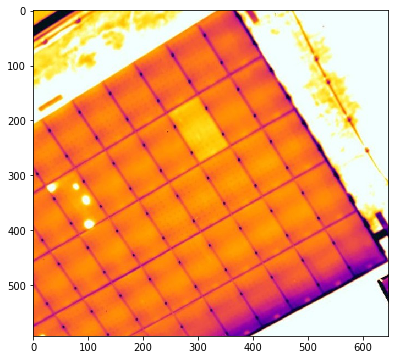

In [35]:
#Plot Image
show_image(TEST_IMAGE_PATHS[2])                             

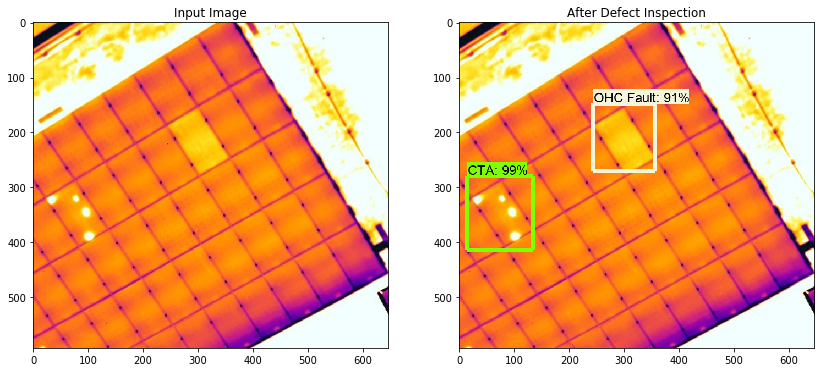

Faults Detected??
Cluster of Thermal Anamolies (CTA)
Over Heating Components Fault (OHC Fault)


In [36]:
class_list=inspect_defect(TEST_IMAGE_PATHS[2])

In [37]:
print_causes_of_fault(class_list)

What are these fault?? 

CTA:
CTA Fault are the Clusters of Thermal Anomalies where "several" cells are warmer than rest of panel. 
It could occur: 
1. If Diodes are defective.  
2. If panel is broken

OHC Fault:
OHC Fault is Over Heating Components Fault where one module/panel is hotter than the others.
It could occur due to: 
Overheating of components in junction and connection boxes



In [38]:

print_prescription_of_fault(class_list)

Prescriptive action to be taken?? 

CTA:
1. Shut down power to panel
2. Check panel components & diodes
3. Replace panel if required

OHC Fault:
1. Shut down power for detected panel
2. Identify Overheated Components
3. Replace /Repair it.



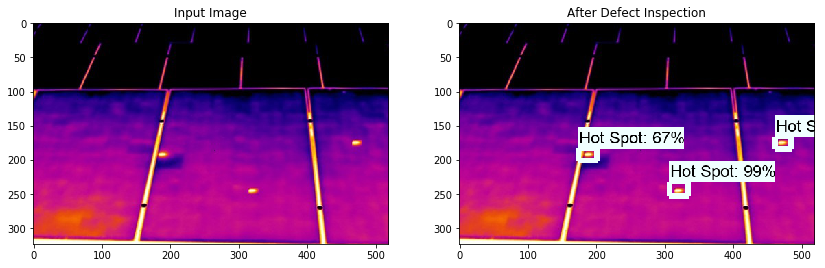

Faults Detected??
Hot Spot


In [39]:
class_list=inspect_defect(TEST_IMAGE_PATHS[4])

In [40]:
print_causes_of_fault(class_list)

What are these fault?? 

Hot Spot:
Hot spots are areas of elevated temperature affecting only part of the solar panel
It could occur:
1.If panel is broken /Dirt is accumulated                                                                                                      



In [41]:
print_prescription_of_fault(class_list)

Prescriptive action to be taken?? 

Hot Spot:
Large temperature diff Hotspot: Panel must be replaced
Small temperature diff Hotspot: Dirt cleaning process must be done for solar panel



### Some of our Best Results

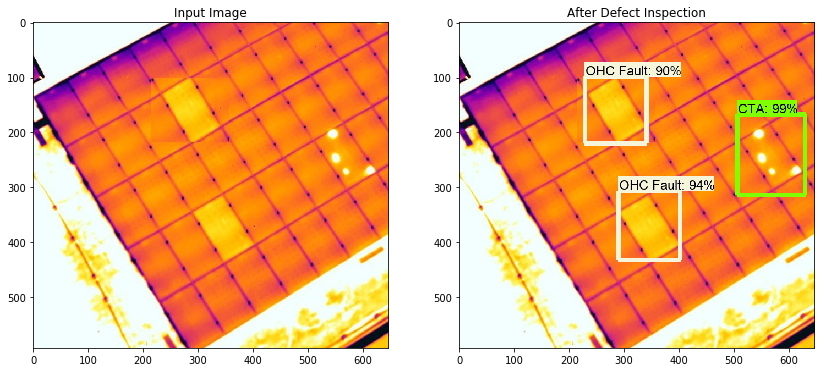

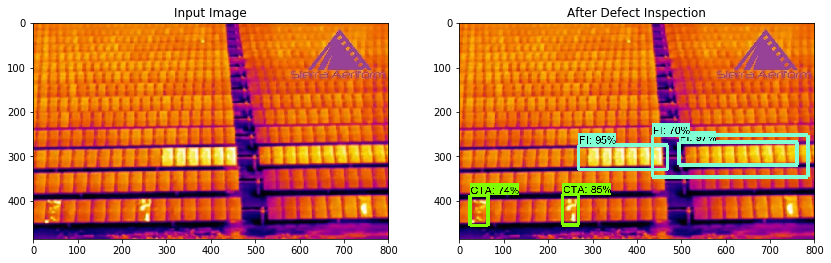

In [42]:
class_list=inspect_defect(TEST_IMAGE_PATHS[75],False)
class_list=inspect_defect(TEST_IMAGE_PATHS[37],False)

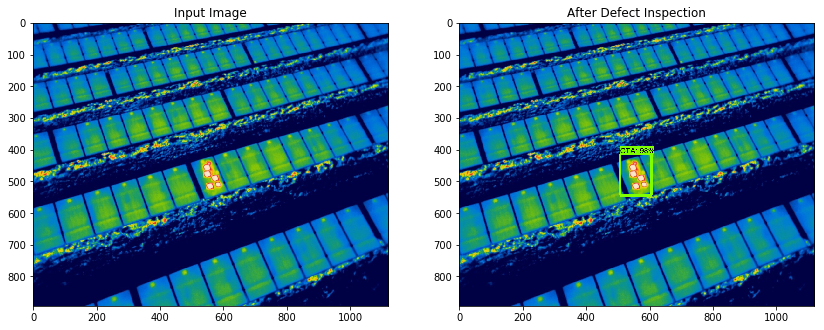

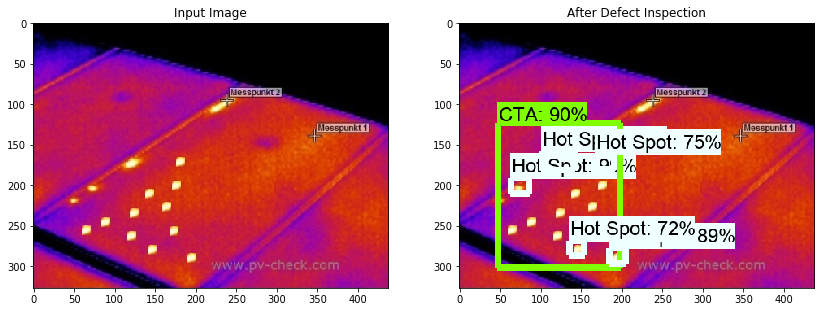

In [43]:
class_list=inspect_defect(TEST_IMAGE_PATHS[39],False)
class_list=inspect_defect(TEST_IMAGE_PATHS[35],False)

### Misclassification

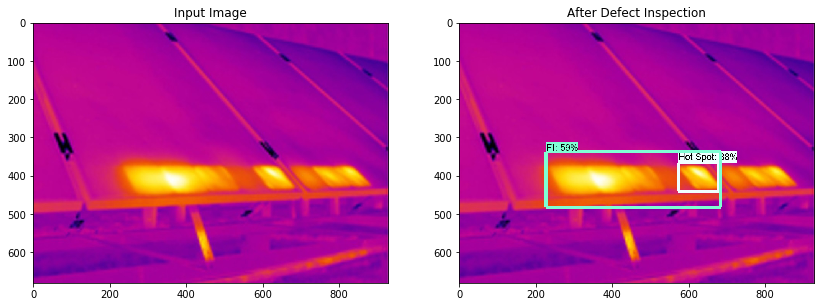

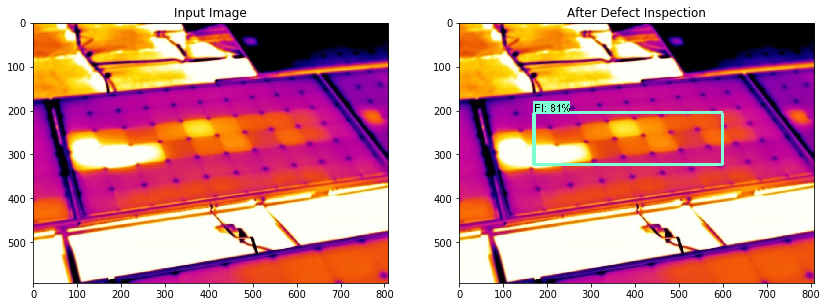

In [44]:
class_list=inspect_defect(TEST_IMAGE_PATHS[101],False)
class_list=inspect_defect(TEST_IMAGE_PATHS[53],False)

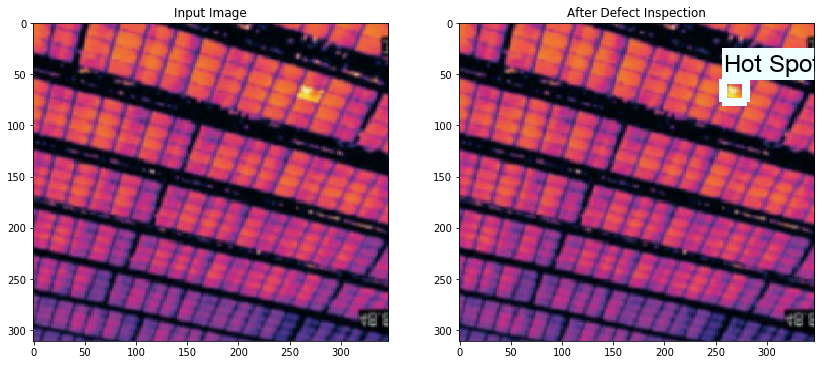

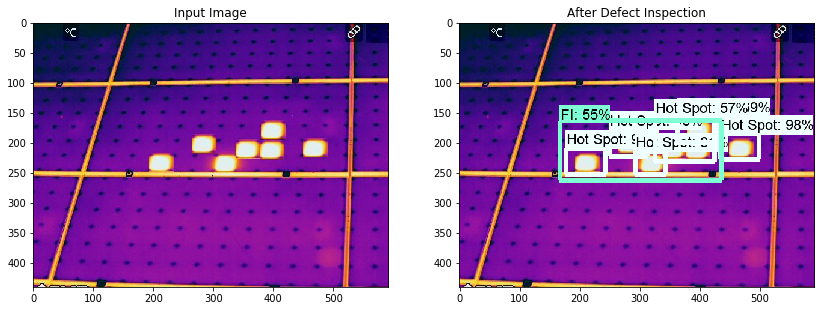

In [45]:
class_list=inspect_defect(TEST_IMAGE_PATHS[10],False)
class_list=inspect_defect(TEST_IMAGE_PATHS[14],False)